# Simulation of observed spectrum

- author : Sylvie Dagoret-Campagne
- date july 4th 2017

In [137]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [138]:
print(theNotebook)

GenerateSimulationProfiles


In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
from astropy.table import Table, Column
import re
import os

In [140]:
import pandas as pd

In [141]:
from matplotlib.backends.backend_pdf import PdfPages

### Import libradtan tools for simulation

In [142]:
import sys
sys.path.append('../../spectrumsim/libradtransim')

In [143]:
from libsimulateTranspCTIOScattAbs import *

In [144]:
sys.path.append('../../spectrumsim')
import libCTIOTransm as ctiosim 

In [145]:
sys.path.append('../../humidity')
import humidity as hum
import libhumidity_ctio as humctio

### import pysynphot tools for CALSPEC SED

In [146]:
os.environ['PYSYN_CDBS']

'/Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs'

In [147]:
import pysynphot as S
from astropy.io import ascii

### CTIO Properties

In [148]:
path_ctiodata='../../spectrumsim/CTIOThroughput'
qe_filename='qecurve.txt'

### esthetic

In [149]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [150]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [151]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [152]:
infos='ctio08jun2017'

In [153]:
rootpath_rawimage="../OverScanRemove/trim_images"
MIN_IMGNUMBER=144
MAX_IMGNUMBER=357
object_name='HD205905_Jun_08th'
SelectTagRe='^trim_20170608_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^trim_20170608_[0-9]+.fits$'
NBIMGPERLROW=4
calspec_sed='hd205905_stis_003.fits'

In [154]:
logfile='logbk_'+object_name+'_'+infos+'.fits'
pandaslogfile='logbk_'+object_name+'_'+infos+'.csv'

In [155]:
outputfitsfile='AllSimSpectra_'+object_name+'.fits'

In [156]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [157]:
ensure_dir(dir_top_images)

## Get list of airmass

In [158]:
df=pd.read_csv(pandaslogfile)

In [159]:
df.head()

,Unnamed: 0,number,airmass,date,filename,exposure,zenith,temperature,pressure,humidity,windspeed,seeing,filter1,filter2,object
0,0,155,1.252,2017-06-09T06:22:28.198,../OverScanRemove/trim_images/,15.0,37.034000,7.6,784.0,32.0,6.4,0.962,RG715,Ron200,HD205905
1,1,159,1.236,2017-06-09T06:27:05.648,../OverScanRemove/trim_images/,15.0,36.036999,7.7,784.0,43.0,6.5,0.962,RG715,HoloPhP,HD205905
2,2,160,1.232,2017-06-09T06:28:15.158,../OverScanRemove/trim_images/,30.0,35.796001,7.7,784.0,38.0,6.5,0.962,FGB37,HoloPhAg,HD205905
3,3,161,1.228,2017-06-09T06:29:39.401,../OverScanRemove/trim_images/,30.0,35.493000,7.6,784.0,33.0,7.2,0.962,RG715,HoloPhAg,HD205905
4,4,162,1.223,2017-06-09T06:31:05.855,../OverScanRemove/trim_images/,30.0,35.181999,7.7,784.0,32.0,6.9,0.962,FGB37,HoloAmAg,HD205905


In [160]:
airmasses=df["airmass"]
date=df['date']
expo=df['exposure']
datafile=df['filename']
temperature=df['temperature']
pressure=df['pressure']
humidity=df['humidity']
seeing=df['seeing']
thefilter=df['filter1']
disperser=df['filter2']
theobject=df['object']

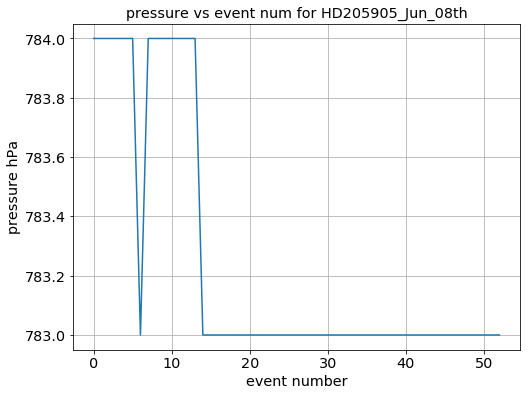

In [161]:
plt.plot(pressure)
thetitle="pressure vs event num for {}".format(object_name)
plt.title(thetitle)
plt.xlabel("event number")
plt.ylabel("pressure hPa")
plt.grid()
plt.savefig("pressurevsnum.pdf")

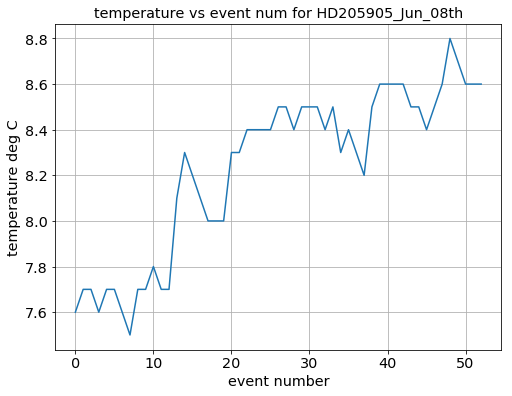

In [162]:
plt.plot(temperature)
thetitle="temperature vs event num for {}".format(object_name)
plt.title(thetitle)
plt.xlabel("event number")
plt.ylabel("temperature deg C")
plt.grid()
plt.savefig("temperaturevsnum.pdf")

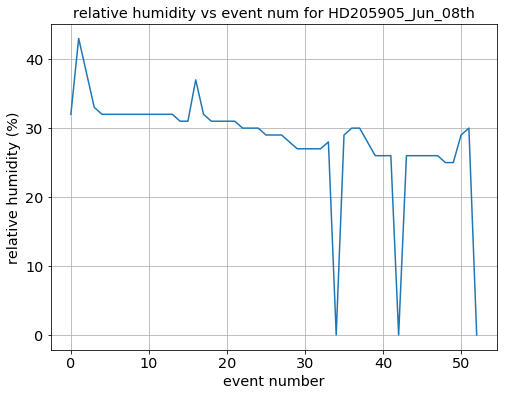

In [163]:
plt.plot(humidity)
thetitle="relative humidity vs event num for {}".format(object_name)
plt.title(thetitle)
plt.xlabel("event number")
plt.ylabel("relative humidity (%)")
plt.grid()
plt.savefig("relhumidityvsnum.pdf")

## Compute pwv required for libradtran

In [164]:
pwv=humctio.HRtoPWV(humidity/100.,pressure,temperature+273.0)

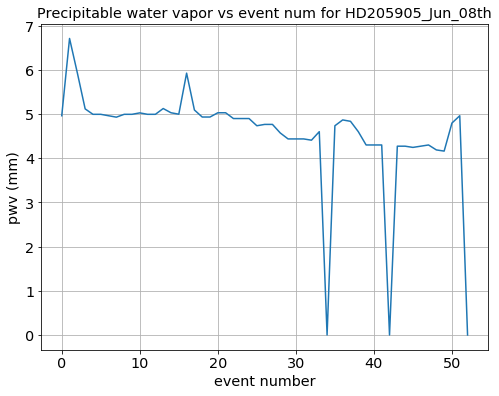

In [165]:
plt.plot(pwv)
thetitle="Precipitable water vapor vs event num for {}".format(object_name)
plt.title(thetitle)
plt.xlabel("event number")
plt.ylabel("pwv (mm)")
plt.grid()
plt.savefig("pwvvsnum.pdf")


## Get quantum efficiency

In [166]:
wl_qe,tr_qe=ctiosim. Get_QE()

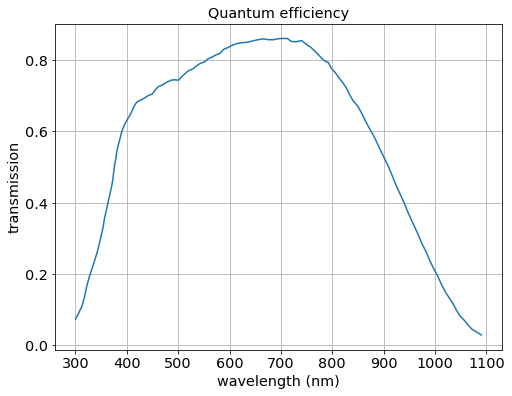

In [167]:
plt.plot(wl_qe,tr_qe)
plt.grid()
plt.title('Quantum efficiency')
plt.xlabel('wavelength (nm)')
plt.ylabel('transmission')

In [168]:
bp_ctio_qe = S.ArrayBandpass(wl_qe*10.,tr_qe, name='CTIO QE')

## Get mirror

In [169]:
wl_m,tr_m=ctiosim. Get_Mirror()

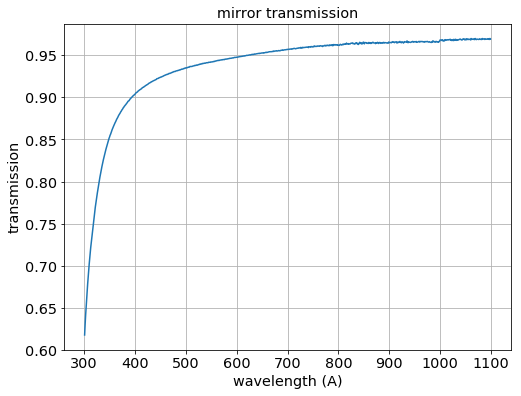

In [170]:
plt.plot(wl_m,tr_m)
plt.grid()
plt.title('mirror transmission')
plt.xlabel('wavelength (A)')
plt.ylabel('transmission')

In [171]:
bp_ctio_m = S.ArrayBandpass(wl_m*10.,tr_m*tr_m, name='CTIO Mirror2')  # two mirrors

### Get Filter

In [172]:
wl_f_red,tr_f_red=ctiosim.Get_RG175()
wl_f_blue,tr_f_blue=ctiosim.Get_FGB37()

In [173]:
bp_ctio_f_red = S.ArrayBandpass(wl_f_red*10.,tr_f_red, name='RG175')  # two mirrors
bp_ctio_f_blue = S.ArrayBandpass(wl_f_blue*10.,tr_f_blue, name='FGB37')  # two mirrors

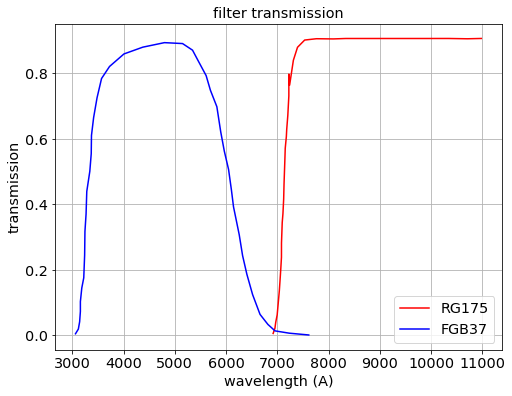

In [174]:
plt.plot(bp_ctio_f_red.wave,bp_ctio_f_red.throughput,color='red',label='RG175')
plt.plot(bp_ctio_f_blue.wave,bp_ctio_f_blue.throughput,color='blue',label='FGB37')
plt.grid()
plt.title('filter transmission')
plt.xlabel('wavelength (A)')
plt.ylabel('transmission')
plt.legend()

### Combine

#### With filter

In [175]:
bp_ctio_red=bp_ctio_qe*bp_ctio_m*bp_ctio_f_red
bp_ctio_blue=bp_ctio_qe*bp_ctio_m*bp_ctio_f_blue

#### witout filter

In [176]:
bp_ctio_nof=bp_ctio_qe*bp_ctio_m

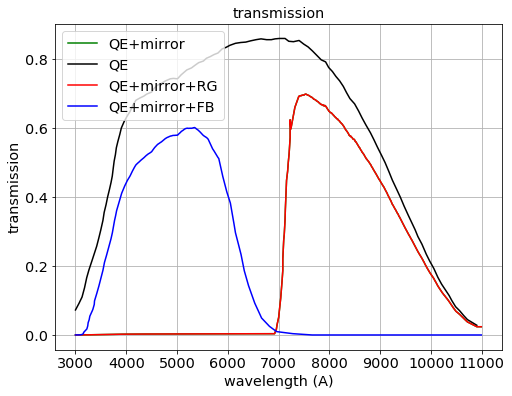

In [177]:
plt.plot(bp_ctio.wave,bp_ctio.throughput,'g-',label='QE+mirror')
plt.plot(wl_qe*10,tr_qe,'k-',label='QE')
plt.plot(bp_ctio_red.wave,bp_ctio_red.throughput,'r-',label='QE+mirror+RG')
plt.plot(bp_ctio_blue.wave,bp_ctio_blue.throughput,'b-',label='QE+mirror+FB')
plt.title('transmission')
plt.xlabel('wavelength (A)')
plt.ylabel('transmission')
plt.grid()
plt.legend()

## Get SED from CALSPEC 

- using Pysynphot

In [178]:
CTIO_COLL_SURF=0.9*(u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [179]:
S.refs.setref(area=CTIO_COLL_SURF.decompose(), waveset=None)
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, delta=10, log=False)

In [180]:
filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec',calspec_sed)
sed = S.FileSpectrum(filename)

Warning, 6 of 3739 bins contained negative fluxes; they have been set to zero.


In [181]:
with fits.open(filename) as pf:
    print(pf[1].header)

XTENSION= 'BINTABLE'           /Written by IDL:  Wed Dec 24 09:04:47 2014       BITPIX  =                    8 /                                                NAXIS   =                    2 /Binary table                                    NAXIS1  =                   30 /Number of bytes per row                         NAXIS2  =                 3739 /Number of rows                                  PCOUNT  =                    0 /Random parameter count                          GCOUNT  =                    1 /Group count                                     TFIELDS =                    7 /Number of columns                               EXTNAME = 'SCI     '           /                                                EXTVER  =                    1 /                                                INHERIT =                    T /                                                TFORM1  = '1D      '           /Real*8 (double precision)                       TTYPE1  = 'WAVELENGTH'         /Label fo

# Simulate atmosphere

In [182]:
all_wl_atm= []
all_tr_atm= []
all_bp_atm = []
PWV=4.
OZ=300.

In [183]:
for index,am in np.ndenumerate(airmasses):
    idx=index[0]
    path,file=ProcessSimulation(am,pwv[idx],OZ,pressure[idx])   
    fullfilename=os.path.join(path,file)
    atm_data=np.loadtxt(fullfilename)
    wl_atm=atm_data[:,0]
    tr_atm=atm_data[:,1]
    all_wl_atm.append(wl_atm)
    all_tr_atm.append(tr_atm)
    atm_filter_name='CTIO atm {}'.format(idx)
    bp_atm = S.ArrayBandpass(wl_atm*10.,tr_atm, name=atm_filter_name)  # Pysynphot pass band
    all_bp_atm.append(bp_atm) 

--------------------------------------------
 2) airmass =  1.25199997425
 2) pwv =  4.96398444252
 3) oz =  300.0
 4) pressure  =  784.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z12_wv49_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z12_wv49_oz30.OUT')
('uvspec cmd: ', '/Users/dagoret-campagnesylvie/MacOsX/LSST/softs/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z12_wv49_oz30.INP > simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z12_wv49_oz30.OUT')
--------------------------------------------
 2) airmass =  1.23599994183
 2) pwv =  6.71370144291
 3) oz =  300.0
 4) pressure  =  784.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z12_wv67_oz30.INP')
('Output to file                : ',

## Observed spectra

- calculate the observed spectra and save it in list

In [184]:
print thefilter

0     RG715
1     RG715
2     FGB37
3     RG715
4     FGB37
5     RG715
6     RG715
7     RG715
8     FGB37
9     RG715
10    RG715
11    RG715
12    FGB37
13    RG715
14    FGB37
15    RG715
16    FGB37
17    RG715
18    RG715
19    RG715
20    RG715
21    FGB37
22    RG715
23    FGB37
24    FGB37
25    FGB37
26    RG715
27    RG715
28    FGB37
29    FGB37
30    FGB37
31    FGB37
32    RG715
33    FGB37
34    RG715
35    FGB37
36    RG715
37    FGB37
38    RG715
39    FGB37
40    RG715
41    FGB37
42    FGB37
43    FGB37
44    RG715
45    RG715
46    FGB37
47    RG715
48    RG715
49    FGB37
50    FGB37
51    FGB37
52    RG715
Name: filter1, dtype: object


In [185]:
all_obs_spectra = []
all_obs_wl= []
all_obs_fluxes = []

for index,am in np.ndenumerate(airmasses):
    idx=index[0]
    if thefilter[idx]=='RG715':
        bp_ctio=bp_ctio_red
    elif thefilter[idx]=='FGB37':
        bp_ctio=bp_ctio_blue
    else:
        bp_ctio=bp_ctio_nof
        
    atm_filter_name='CTIO atm {}'.format(idx)
    the_bp_atm= S.ArrayBandpass(all_wl_atm[idx]*10.,all_tr_atm[idx], name=atm_filter_name)  # Pysynphot pass band
    bp_ctio_atm = bp_ctio*the_bp_atm # Multply atm tansmission by CCD QE efficiciency
    bp_ctio_atm.binning=10.
    obs_ctio = S.Observation(sed,bp_ctio_atm)
    all_obs_spectra.append(obs_ctio)
    all_obs_wl.append(obs_ctio.wave)
    all_obs_fluxes.append(obs_ctio.flux) 
    

((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * FGB37) * CTIO atm 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * FGB37) * CTIO atm 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 6)) does not have a de

(0, 10000)

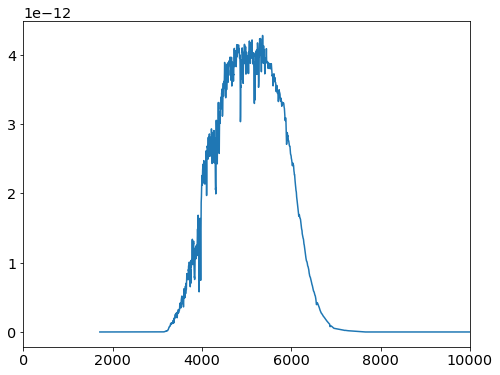

In [186]:
sel=4
plt.plot(all_obs_wl[sel], all_obs_fluxes[sel])
plt.xlim(0,10000)

In [189]:
def MakeSimNpArray(all_simwavelength,all_simspectra):
    
    all_simspectra=np.array(all_simspectra)
    simwavelength=np.array(all_simwavelength[0])
    
    NBSPEC=all_simspectra.shape[0]
    NBWL=simwavelength.shape[0]
    
    print NBSPEC,' , ',NBWL
    dataout=np.zeros((NBSPEC+1,NBWL))
    
    dataout[0,:]=simwavelength
    
    for ispec in np.arange(1,NBSPEC+1):
        dataout[ispec,:]=all_simspectra[ispec-1][0:NBWL]
    return dataout

In [190]:
spectra_out=MakeSimNpArray(all_obs_wl,all_obs_fluxes)

53  ,  4839


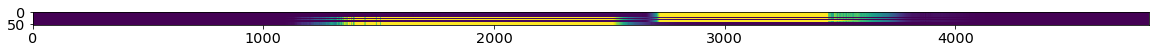

In [191]:
plt.figure(figsize=(20,20))
plt.imshow(spectra_out[:,:],vmin=0,vmax=1e-12)

In [192]:
def CompareSpectrumProfile(allspectra,object_name,dir_top_img):
    """
    CompareSpectrumProfile
    =====================
    
    """
    shortfilename='CompareSimSpec_'+object_name+'.pdf'
    title="Compare simulated spectra of {}".format(object_name)
    figfilename=os.path.join(dir_top_img,shortfilename)
    pp = PdfPages(figfilename) # create a pdf file
    
    
    f, axarr = plt.subplots(1,1,figsize=(25,15))
    f.suptitle(title,size=20)
    
    NBSPEC=allspectra.shape[0]-1
    wl=allspectra[0]
    
    
    min_z=truncate(min(airmasses),2)
    max_z=truncate(max(airmasses),2)
    
    maxim_y_to_plot= []

    texte='airmass : {} - {} '.format(min_z,max_z)
    
    for index in np.arange(0,NBSPEC):
                
       
        axarr.plot(wl,allspectra[index+1],'-')
        maxim_y_to_plot.append(allspectra[index+1].max())
    
    max_y_to_plot=max(maxim_y_to_plot)
    axarr.set_ylim(0,max_y_to_plot)
    axarr.text(0.,max_y_to_plot*0.9, texte ,verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
    axarr.grid(True)
    axarr.set_xlim(0,12000)
    
    axarr.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axarr.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axarr.grid(b=True, which='major', color='k', linewidth=2.0)
    axarr.grid(b=True, which='minor', color='grey', linewidth=0.5)
    
    
    
    axarr.set_xlabel("wavelength (A)")
    
        
    f.savefig(pp, format='pdf')
    f.show()
    
    pp.close()     
    

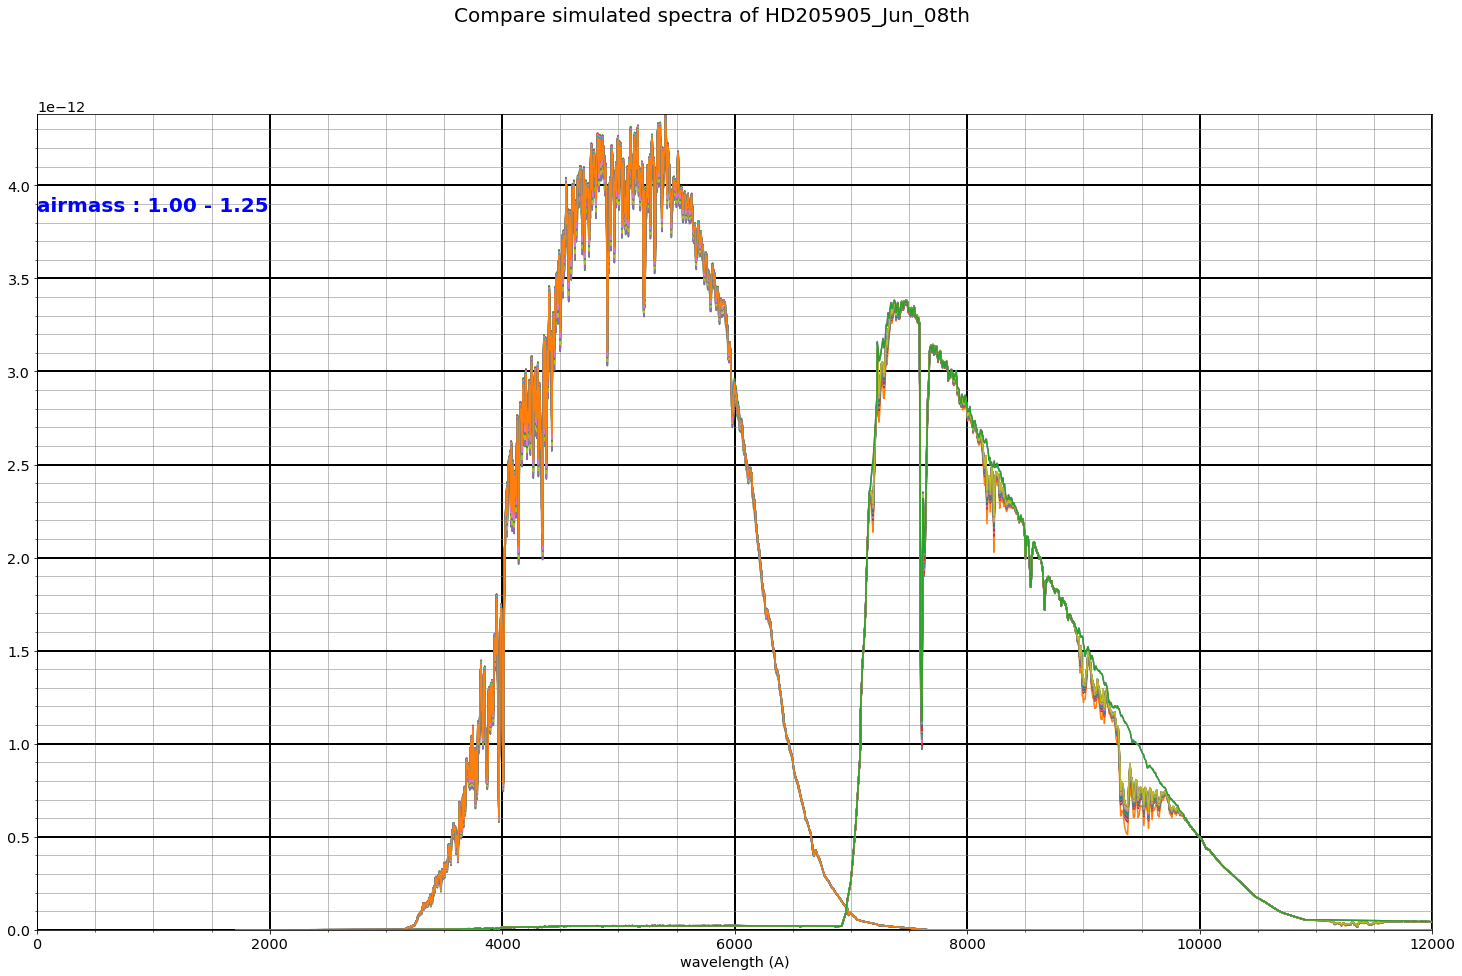

In [193]:
CompareSpectrumProfile(spectra_out,object_name,dir_top_images)

## Save output file

In [194]:
prihdu = fits.PrimaryHDU(data=spectra_out)
thdulist = fits.HDUList(prihdu)
thdulist.writeto(outputfitsfile,overwrite=True)

In [195]:
spectra_out.shape

(54, 4839)